# Based on Chapter 3 in O'Reilly book "Hands on Machine Learning 2"

## This notebook is based on the notebook accompanying this chapter  
The notebook is stored here on GCP, the relative path to this one is ../../handson-ml2/handson-ml2/03_classification.ipynb
#### We read in the Fasttext embedding already created and apply binary classification following the chapter
#### The notebook Non_binary_classification.ipynb follows on with non-binary classification

# Setup

In [82]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [83]:
# sklearn imports
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score


from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score


# imbalanced dataset metrics
# NOTE: I had some difficulty getting imblearn to run on my home PC, the !pip install was needed here as it didn't work installing in the terminal
# !pip install imblearn
from imblearn.metrics import classification_report_imbalanced


## Import vectorized CPA data
The vectorized columns are as follows:    
- Descr_cleaned_vectorized : FastText vectorization of the "Descr_cleaned" column
- Full_descr_cleaned_vectorized : FastText vectorization of the "Full_descr_cleaned" column
- Descr_Low_dim : Reduced dimension (UMAP 10 dimensions) of FastText vectorization of the "Descr_cleaned" column
- Full_descr_Low_dim : Reduced dimension (UMAP 10 dimensions) of FastText vectorization of the "Full_descr_cleaned" column

The first two columns listed above hold the full vectorization (about 300 dim- check) and the "Low_dim" ones are reduced dimenstion

In [84]:
# we need to ensure the columns of lists are imported as such
import ast
generic = lambda x: ast.literal_eval(x)
conv = {
        'Descr_Low_dim': generic,
        'Full_descr_Low_dim': generic}
CPA = pd.read_csv('../data/output/CPA_Vectorized.csv', converters=conv)

CPA = CPA[CPA.Level==6]
CPA = CPA.astype({'Category_0':int,'Category_2':int})
CPA.head()


,Code,Level,Descr_old,Descr,Includes,Category_0,Category_1,Category_2,Full_descr,Descr_cleaned,Full_descr_cleaned,Descr_cleaned_vectorized,Full_descr_cleaned_vectorized,Descr_Low_dim,Full_descr_Low_dim
5,01.11.11,6,Durum wheat,Durum wheat,NaN,1,A,1,Durum wheat,durum wheat,durum wheat,[-0.07021299 0.07487412 -0.08852207 -0.093424...,[-0.07021299 0.07487412 -0.08852207 -0.093424...,"[10.613475799560547, 1.6112016439437866, 6.889...","[10.080077171325684, 3.1135828495025635, 5.750..."
6,01.11.12,6,"Wheat, except durum wheat",Wheat,NaN,1,A,1,"Wheat, except durum wheat",wheat,wheat except durum wheat,[ 6.82471097e-02 5.72879892e-03 -2.74024643e-...,[-8.17044750e-02 4.43322510e-02 -1.21796057e-...,"[10.610937118530273, 1.6146502494812012, 6.886...","[10.07783031463623, 3.1349775791168213, 5.7314..."
8,01.11.20,6,Maize,Maize,NaN,1,A,1,Maize,maize,maize,[-2.75462180e-01 2.88966715e-01 -1.60463899e-...,[-2.75462180e-01 2.88966715e-01 -1.60463899e-...,"[10.598653793334961, 1.5319408178329468, 6.899...","[10.088605880737305, 3.1780178546905518, 5.732..."
10,01.11.31,6,Barley,Barley,NaN,1,A,1,Barley,barley,barley,[-0.48283365 -0.02554321 -0.09297911 0.358175...,[-0.48283365 -0.02554321 -0.09297911 0.358175...,"[10.606842994689941, 1.6108537912368774, 6.884...","[10.082571983337402, 3.0978615283966064, 5.779..."
11,01.11.32,6,Rye,Rye,NaN,1,A,1,Rye,rye,rye,[-0.23049644 0.07332443 -0.51851004 0.030723...,[-0.23049644 0.07332443 -0.51851004 0.030723...,"[10.645343780517578, 1.672475814819336, 6.8885...","[10.067237854003906, 3.0663797855377197, 5.772..."


## Split the CPA data into a training and a test set

In [ ]:
from sklearn.model_selection import train_test_split

# Split the CPA dataframe into train and test
train_set, test_set = train_test_split(CPA, test_size=0.2, random_state=42)
# The vector column will be the data we use for classification
col = 'Descr_Low_dim'
X_train = np.array(list(train_set[col]))
X_test = np.array(list(test_set[col]))

# we will use different levels of categorisation
# we can choose the level of categorisation here, Category_0, _1 or _2, and also the vectorisation to use
Cat = 'Category_0'
y_train_cat0 = np.array(list(train_set[Cat]))
y_test_cat0 = np.array(list(test_set[Cat]))
Cat = 'Category_1'
y_train_cat1 = np.array(list(train_set[Cat]))
y_test_cat1 = np.array(list(test_set[Cat]))
Cat = 'Category_2'
y_train_cat2 = np.array(list(train_set[Cat]))
y_test_cat2 = np.array(list(test_set[Cat]))

print(X_train.shape, y_train_cat1.shape)
X_train[:2]

# Binary classifier
The binary classifier will simply determine whether an item is in our chosen class or not.


In [86]:
# These are the labels or actual classes we train data on
y_train_cat1

array(['A', 'K', 'A', ..., 'C', 'C', 'S'], dtype='<U1')

In [87]:
## Try with y_train == 
chosen_class = 'C'
y_train_C = (y_train_cat1 == chosen_class)
y_test_C = (y_test_cat1 == chosen_class)


## Binary Classification with Stochastic Gradient Descent

In [88]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_cat1, y_train_C)

SGDClassifier(random_state=42)

## Assess the accuracy, precision and recall of the classification

In [89]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_cat1, y_train_C, cv=3, scoring="accuracy")

array([0.56759907, 0.82867133, 0.83216783])

## Never Classifier: never choose our class
Example from the Book: In the case where one in ten items belong to our class, then the "Never Classifier" trivially assigns all items to be not in the class. We note that in this case there would be 90% accuracy, which puts into context the notion of accuracy.

In [90]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [91]:
never_5_clf = Never5Classifier()
print('')
cross_val_score(never_5_clf, X_train_cat1, y_train_C, cv=3, scoring="accuracy")

array([0.43473193, 0.46969697, 0.45221445])

## Learning from the Confusion Matrix
precision=TP / (TP + FP)   
recall = TP / (TP + FN)

In [92]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train_cat1, y_train_C, cv=3)

In [93]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score


CM = confusion_matrix(y_train_C, y_train_pred)
TN = CM[0,0]
FP = CM[0,1]
FN = CM[1,0]
TP = CM[1,1]
print('Confusion matrix \n', CM, '\n\n [TN, FP]\n [FN, TP]\n')
print('Precision TP/(TP+FP)', TP/(TP+FP), ' sklearn precision score:', precision_score(y_train_C, y_train_pred))
print('Recall TP/(TP+FN)', TP/(TP+FN), ' sklearn recall score:', recall_score(y_train_C, y_train_pred))
print('sklearn F1 score: ',f1_score(y_train_C, y_train_pred))




Confusion matrix 
 [[1036  128]
 [ 534  876]] 

 [TN, FP]
 [FN, TP]

Precision TP/(TP+FP) 0.8725099601593626  sklearn precision score: 0.8725099601593626
Recall TP/(TP+FN) 0.6212765957446809  sklearn recall score: 0.6212765957446809
sklearn F1 score:  0.7257663628831814


### What would the confusion matrix look like if we had a perfect prediction?

In [94]:
y_train_perfect_predictions = y_train_C  # pretend we reached perfection
CMP = confusion_matrix(y_train_C, y_train_perfect_predictions)
CMP

array([[1164,    0],
       [   0, 1410]])

## Relative benefits of precision and recall
The F1 score (harmonic mean of precision and recall) favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

** High precision: few missclassified **   
If you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). 

** High recall: few missed **   
On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).



## Look at the descision function to tune the classifier
Use the precision_recall_curve() function to compute precision and recall for all possible thresholds:

In [95]:
y_scores = cross_val_predict(sgd_clf, X_train_cat1, y_train_C, cv=3,
                             method="decision_function")

In [96]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_C, y_scores)

###  plot precision and recall as functions of the threshold value 

Saving figure precision_recall_vs_threshold_plot


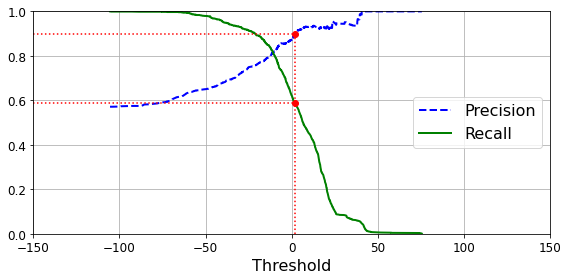

In [97]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-150, 150, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-150, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-150, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

### Another way to select a good precision/recall trade-off is to plot precision directly against recall

In [98]:
print('Recall 90% precision',recall_90_precision, '\nThreshold 90% precision', threshold_90_precision)

Recall 90% precision 0.5893617021276596 
Threshold 90% precision 1.8600394293490865


Saving figure precision_vs_recall_plot


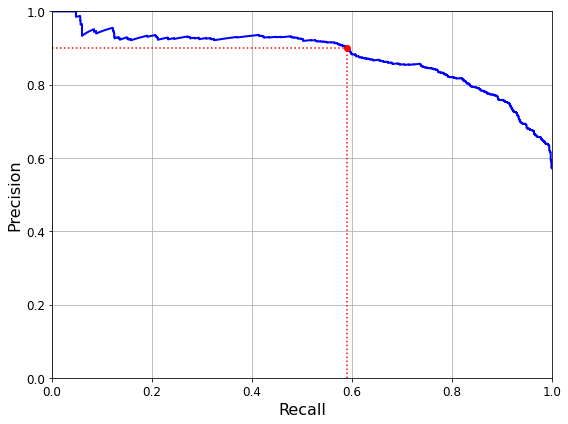

In [99]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

## We now set our SGD classifier to have a recall of 90%

In [100]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [101]:
print('Precision score is over 90% as expected: ', precision_score(y_train_C, y_train_pred_90))
print('Recall score has gone down as expected: ', recall_score(y_train_C, y_train_pred_90))

Precision score is over 90% as expected:  0.9003250270855905
Recall score has gone down as expected:  0.5893617021276596


## ROC curves
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [102]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_C, y_scores)

Saving figure roc_curve_plot


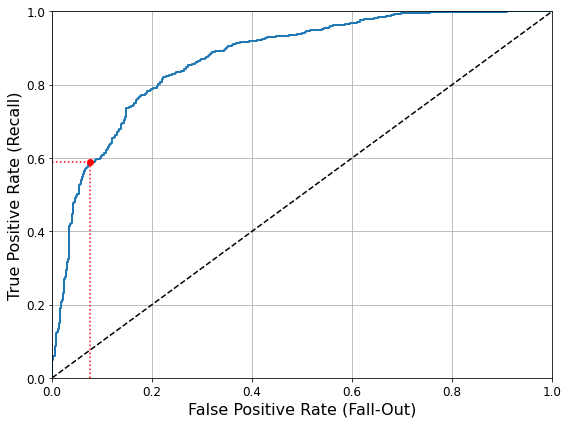

In [103]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

red_dot_point = 0.075 # estimating
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([red_dot_point, red_dot_point], [0., recall_90_precision], "r:") # Not shown
plt.plot([0.0, red_dot_point], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([red_dot_point], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

### Area Under Curve
One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier (shown by diagonal dashed black line) will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC

In [104]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_C, y_scores)

0.8728711218347105

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

## Binary Classification with Random Forest Classifier

In [105]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_cat1, y_train_C, cv=3,
                                    method="predict_proba")

In [106]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_C,y_scores_forest)

Saving figure roc_curve_comparison_plot


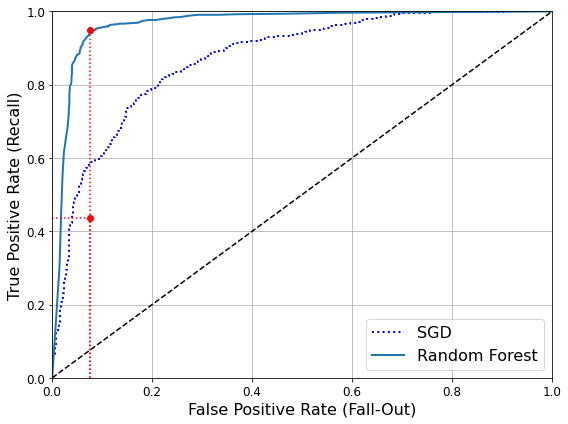

In [107]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([red_dot_point, red_dot_point], [0., 0.4368], "r:")
plt.plot([0.0, red_dot_point], [0.4368, 0.4368], "r:")
plt.plot([red_dot_point], [0.4368], "ro")
plt.plot([red_dot_point, red_dot_point], [0., 0.9487], "r:")
plt.plot([red_dot_point], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [108]:
print('ROC AUC score: ',roc_auc_score(y_train_C, y_scores_forest))

ROC AUC score:  0.9661457190904439


In [109]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train_cat1, y_train_C, cv=3)
print('Precision score :',precision_score(y_train_C, y_train_pred_forest))
print('Recall score :',recall_score(y_train_C, y_train_pred_forest))

Precision score : 0.9334733893557423
Recall score : 0.9453900709219858


## Repeat Binary Classification with Random Forest for Category_0
This is a higher level of categorisation
NOTE: there are 10 categories from 0 to 9, and category 2 holds about half of the records, so the data is very imbalanced.   
We need to address this later, and for now we only try this class, which should be the easist to predict

In [110]:
Cat = 'Category_0'
col = 'Descr_Low_dim'
X_train_cat0, X_test_cat0, y_train_cat0, y_test_cat0 = get_test_train(CPA, Cat, col)
## set chosen class for the binary classifier 
chosen_class = 2
y_train_2 = (y_train_cat0 == chosen_class)
y_test_2 = (y_test_cat0 == chosen_class)
# These are the labels or actual classes we train data on
y_train_cat0
print('Length all data: ',len(y_train_cat0),'\nLength "Category_0 = 2" data: ', len(y_train_2[y_train_2]))
print('Percentage in this category: ', len(y_train_2[y_train_2])/len(y_train_cat0)*100 )

Length all data:  2574 
Length "Category_0 = 2" data:  1509
Percentage in this category:  58.624708624708624


In [111]:
Cat = 'Category_0'
col = 'Descr_Low_dim'
X_train_cat0, X_test_cat0, y_train_cat0, y_test_cat0 = get_test_train(CPA, Cat, col)
## set chosen class for the binary classifier 
chosen_class = 2
y_train_2 = (y_train_cat0 == chosen_class)
y_test_2 = (y_test_cat0 == chosen_class)

# set up random forest classifier
y_probas_forest0 = cross_val_predict(forest_clf, X_train_cat0, y_train_2, cv=3,
                                    method="predict_proba")

y_scores_forest_0 = y_probas_forest[:, 1] # score = proba of positive class
y_train_pred_forest_0 = cross_val_predict(forest_clf, X_train_cat0, y_train_2, cv=3)

print('AUC score for Category_0 class 2: ', roc_auc_score(y_train_2, y_scores_forest_0))
print('Precision score for Category_0 class 2: ', precision_score(y_train_2, y_train_pred_forest_0))
print('Recall score for Category_0 class 2: ', recall_score(y_train_2, y_train_pred_forest_0))


AUC score for Category_0 class 2:  0.9444618672938894
Precision score for Category_0 class 2:  0.9485488126649076
Recall score for Category_0 class 2:  0.9529489728296885


# Imbalanced Data Metrics
Our data is imbalanced in the sense that the numbers of items in each class varies a lot.   
This section diagresses from the book.

NOTE: I had quite a lot of difficulty getting VS Code to recognise imblearn. Finally it worked using !pip install imblearn in jupyter cell directly

In [112]:
print(classification_report_imbalanced(y_train_C, y_train_pred_forest))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.93      0.92      0.95      0.93      0.93      0.87      1164
       True       0.93      0.95      0.92      0.94      0.93      0.87      1410

avg / total       0.93      0.93      0.93      0.93      0.93      0.87      2574



In [113]:
print(classification_report_imbalanced(y_train_2, y_train_pred_forest_0))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.93      0.93      0.95      0.93      0.94      0.88      1065
       True       0.95      0.95      0.93      0.95      0.94      0.89      1509

avg / total       0.94      0.94      0.94      0.94      0.94      0.88      2574



# Multiclass classification
Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as SGD Classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

** One-versus-rest **   
One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

** One-versus-one **   
Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) *scale poorly with the size of the training set*. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. ** For most binary classification algorithms, however, OvR is preferred. **


## Support Vector Machine classifier
Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the sklearn.svm.SVC class:

In [114]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train_cat1, y_train_cat1) # y_train, not y_train_binary


SVC(gamma='auto', random_state=42)

In [115]:
## To follow the book, let's set up a test item. The class should be 'C'
test_item = CPA[CPA.Category_1=='C'].iloc[438].Descr_Low_dim
svm_clf.predict([test_item])

array(['C'], dtype='<U1')

Under the hood, Scikit-Learn actually used the OvO strategy: it trained N * (N-1) binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it returns N scores per instance (instead of just 1). That’s one score per class (it’s the number of won duels plus or minus a small tweak to break ties, based on the binary classifier scores)

In [116]:
some_digit_scores = svm_clf.decision_function([test_item])
some_digit_scores

array([[18.30169153, 10.22993143, 20.31857842, 10.21599858, 12.28365483,
        17.3076748 , 14.29589074,  7.73826124,  4.69463905, 19.3144225 ,
         3.69376389,  1.68671612, 16.30424451, 12.27334282,  2.69176576,
         5.70107527,  6.70662097, 11.24100426, 15.29481816,  0.68748909,
        -0.31568006]])

In [117]:
svm_clf.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'], dtype='<U1')

** The highest score is indeed the one corresponding to class 'C' **

In [51]:
svm_clf.classes_[2]

'C'

### Try out the accuracy measures for this classifier

In [52]:
cross_val_score(svm_clf, X_train_cat1, y_train_cat1, cv=3, scoring="accuracy")

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.82400932, 0.82517483, 0.81701632])

In [53]:
y_train_pred_tmp = cross_val_predict(svm_clf, X_train_cat1, y_train_cat1, cv=3)
conf_mx_tmp = confusion_matrix(y_train_cat1, y_train_pred_tmp)
conf_mx_tmp

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([[  78,    0,   78,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    0,    0,    0,    0,    0,    2,    0,    0],
       [   0,    0,   29,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  30,    1, 1330,    0,    0,    1,   15,   14,    0,   14,    0,
           0,    2,    3,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    7,    3,    0,    0,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   11,    0,   47,    0,    0,    0,    0,    0,    0,
           0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   19,    0,    0,   43,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    2,    1,    0,    0,    0],
       [   0,    0,   19,    0,    0,    0,  162,    0,    0,    5,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],

In [54]:
print(classification_report_imbalanced(y_train_cat1, y_train_pred_tmp))

                   pre       rec       spe        f1       geo       iba       sup

          A       0.72      0.49      0.99      0.58      0.70      0.46       159
          B       0.00      0.00      1.00      0.00      0.00      0.00        29
          C       0.87      0.94      0.83      0.91      0.89      0.79      1410
          D       1.00      0.27      1.00      0.43      0.52      0.25        11
          E       0.96      0.80      1.00      0.87      0.89      0.78        59
          F       0.93      0.65      1.00      0.77      0.81      0.63        66
          G       0.83      0.87      0.99      0.85      0.93      0.85       186
          H       0.82      0.79      0.99      0.80      0.88      0.76        98
          I       0.79      0.61      1.00      0.69      0.78      0.59        18
          J       0.67      0.87      0.98      0.76      0.93      0.85       110
          K       0.87      0.85      1.00      0.86      0.92      0.83        71
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Repeat this for the Category_0 classification

In [55]:
y_train_pred_0 = cross_val_predict(svm_clf, X_train_cat0, y_train_cat0, cv=3)
print(classification_report_imbalanced(y_train_cat0, y_train_pred_0))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.72      0.49      0.99      0.58      0.70      0.46       159
          2       0.91      0.95      0.86      0.93      0.90      0.82      1509
          3       0.96      0.67      1.00      0.79      0.82      0.64        66
          4       0.78      0.88      0.97      0.83      0.92      0.84       302
          5       0.68      0.85      0.98      0.75      0.91      0.82       110
          6       0.88      0.85      1.00      0.86      0.92      0.83        71
          7       0.94      1.00      1.00      0.97      1.00      1.00        15
          8       0.72      0.65      0.98      0.68      0.80      0.61       184
          9       0.79      0.74      0.99      0.77      0.86      0.72        86
         10       0.67      0.36      0.99      0.47      0.60      0.34        72

avg / total       0.85      0.85      0.91      0.85      0.87      0.77      2574



If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [56]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train_cat1, y_train_cat1)

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [57]:
len(ovr_clf.estimators_)

21

In [58]:
cross_val_score(ovr_clf, X_train_cat1, y_train_cat1, cv=3, scoring="accuracy")

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.81585082, 0.81934732, 0.80652681])

In [59]:
y_train_pred_ovr = cross_val_predict(ovr_clf, X_train_cat1, y_train_cat1, cv=3)
print(classification_report_imbalanced(y_train_cat1, y_train_pred_ovr))
y_train_pred_ovr0 = cross_val_predict(ovr_clf, X_train_cat0, y_train_cat0, cv=3)
print(classification_report_imbalanced(y_train_cat0, y_train_pred_ovr0))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

          A       0.72      0.42      0.99      0.53      0.64      0.39       159
          B       0.00      0.00      1.00      0.00      0.00      0.00        29
          C       0.86      0.94      0.82      0.90      0.88      0.78      1410
          D       1.00      0.27      1.00      0.43      0.52      0.25        11
          E       0.91      0.81      1.00      0.86      0.90      0.80        59
          F       0.79      0.68      1.00      0.73      0.82      0.66        66
          G       0.83      0.82      0.99      0.83      0.90      0.80       186
          H       0.79      0.80      0.99      0.79      0.89      0.77        98
          I       0.75      0.33      1.00      0.46      0.58      0.31        18
          J       0.65      0.89      0.98      0.75      0.93      0.86       110
          K       0.82      0.87      0.99      0.84      0.93      0.86        71
   

## Stochastic Gradient Descent Multi classifier
Training an SGDClassifier is just as easy

In [60]:
sgd_clf.fit(X_train_cat1, y_train_cat1)

SGDClassifier(random_state=42)

This time Scikit-Learn used the OvR strategy under the hood: since there are N classes, it trained N binary classifiers. The decision_function() method now returns one value per class. Let’s look at the score that the SGD classifier assigned to each class:

In [61]:
sgd_clf.decision_function([test_item])

array([[ -19.59777066,  -53.4049766 ,    4.82074766,  -57.01429805,
         -34.40895527,  -77.28092638,  -27.38892744,  -34.52738137,
          -2.97945232,  -29.41250031,  -48.17511284,  -74.01339338,
         -21.88581657,  -25.52490274,  -67.9379445 ,  -51.80721982,
         -43.06197861,  -53.11652044,  -21.53340544,  -79.91837538,
        -115.23741774]])

In [62]:
cross_val_score(sgd_clf, X_train_cat1, y_train_cat1, cv=3, scoring="accuracy")

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.75291375, 0.71794872, 0.74825175])

## Improving results using a scaler
These results are already a lot better than a random classifier.   
QUESTION: since our data is already vectorized, is using this scalar meaningful?

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cat1.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train_cat1, cv=3, scoring="accuracy")

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.75058275, 0.75641026, 0.75291375])

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train_cat1, cv=3)
conf_mx = confusion_matrix(y_train_cat1, y_train_pred)
conf_mx

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([[  67,    0,   88,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    3,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   27,    1,    0,    0,    0,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  60,    1, 1297,    1,    0,    2,    5,   23,    0,   14,    0,
           0,    1,    3,    0,    0,    0,    1,    2,    0,    0],
       [   0,    0,    6,    4,    0,    0,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    9,    1,   47,    0,    0,    0,    0,    0,    0,
           0,    0,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   14,    0,    0,   40,    1,    4,    0,    0,    0,
           0,    0,    7,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,   57,    0,    0,    0,  123,    0,    0,    5,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],

In [65]:
print(classification_report_imbalanced(y_train_cat1, y_train_pred))

                   pre       rec       spe        f1       geo       iba       sup

          A       0.52      0.42      0.97      0.46      0.64      0.39       159
          B       0.00      0.00      1.00      0.00      0.00      0.00        29
          C       0.84      0.92      0.78      0.88      0.85      0.73      1410
          D       0.57      0.36      1.00      0.44      0.60      0.34        11
          E       0.96      0.80      1.00      0.87      0.89      0.78        59
          F       0.77      0.61      1.00      0.68      0.78      0.58        66
          G       0.85      0.66      0.99      0.74      0.81      0.63       186
          H       0.68      0.80      0.99      0.73      0.89      0.77        98
          I       0.00      0.00      1.00      0.00      0.00      0.00        18
          J       0.61      0.89      0.97      0.73      0.93      0.86       110
          K       0.81      0.77      0.99      0.79      0.88      0.75        71
   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
y_train_pred_0 = cross_val_predict(sgd_clf, X_train_scaled, y_train_cat0, cv=3)
X_train_scaled_0 = scaler.fit_transform(X_train_cat0.astype(np.float64))
print(classification_report_imbalanced(y_train_cat0, y_train_pred_0))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.48      0.57      0.96      0.52      0.74      0.52       159
          2       0.90      0.88      0.87      0.89      0.87      0.77      1509
          3       0.74      0.64      0.99      0.68      0.80      0.61        66
          4       0.67      0.79      0.95      0.73      0.87      0.74       302
          5       0.61      0.86      0.98      0.71      0.92      0.83       110
          6       0.79      0.85      0.99      0.82      0.92      0.83        71
          7       1.00      0.33      1.00      0.50      0.58      0.31        15
          8       0.57      0.48      0.97      0.52      0.68      0.44       184
          9       0.80      0.57      1.00      0.67      0.75      0.54        86
         10       0.21      0.14      0.98      0.17      0.37      0.13        72

avg / total       0.78      0.78      0.91      0.78      0.83      0.70      2574



Saving figure confusion_matrix_plot


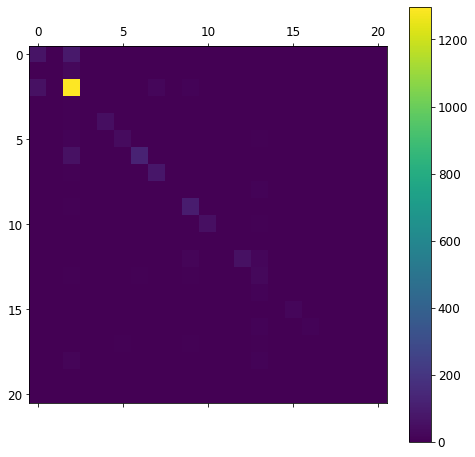

In [67]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

#plt.matshow(conf_mx, cmap=plt.cm.gray) # greyscale version
plot_confusion_matrix(conf_mx)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


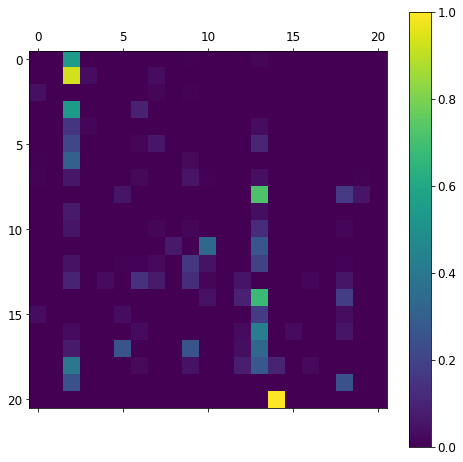

In [69]:
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()